In [2]:
from nilearn.surface import load_surf_data
import numpy as np
import pandas as pd
from os.path import isfile

In [10]:
def extract_curv(in_dir, out_file):
    pheno_file = in_dir + '/participants.tsv'
    pheno = pd.read_csv(pheno_file, sep='\t')

    curv_pd = pd.DataFrame()
    for sub in np.arange(1, 226):
        subject = 'sub-' + str(sub).zfill(4)
        sub_dir = in_dir + '/derivatives/freesurfer/' + subject

        handedness = pheno['handedness'].loc[pheno['participant_id'] == subject].values
        sex = pheno['sex'].loc[pheno['participant_id'] == subject].values

        for hemi in ['lh', 'rh']:
            annot_file = sub_dir + '/label/' + hemi + '.aparc.a2009s.annot'
            curv_file = sub_dir + '/surf/' + hemi + '.curv'
            if isfile(annot_file) and isfile(curv_file):
                annot = load_surf_data(annot_file)
                curv = load_surf_data(curv_file)
                cent_curv = np.array([curv[i] for i, value in enumerate(annot) if value == 46])
                pos_curv = np.mean(cent_curv[cent_curv > 0])
                neg_curv = np.mean(cent_curv[cent_curv < 0])
                mean_curv = np.mean(np.absolute(cent_curv))
                curr = pd.DataFrame({'Subject': subject, 'Hemisphere': hemi, 
                                     'Mean absolute curvature': mean_curv,
                                     'Mean positive curvature': pos_curv,
                                     'Mean negative curvature': neg_curv,
                                     'Handedness': handedness, 'Sex': sex}, index=[0])
                curv_pd = curv_pd.append(curr, ignore_index=True)

    curv_pd.to_csv(out_file)
    return curv_pd

In [27]:
#curv_piop1 = extract_curv('/Users/jwu/brainhack/bhPadova_2020/data/aomic_piop1', '/Users/jwu/brainhack/bhPadova_2020/mean_curv_piop1.csv')
#curv_piop2 = extract_curv('/Users/jwu/brainhack/bhPadova_2020/data/aomic_piop2', '/Users/jwu/brainhack/bhPadova_2020/mean_curv_piop2.csv')
curv_piop1 = pd.read_csv('/Users/jwu/brainhack/bhPadova_2020/mean_curv_piop1.csv', usecols=range(1,8))
curv_piop1['Dataset'] = 'AOMIC-PIOP1'
curv_piop2 = pd.read_csv('/Users/jwu/brainhack/bhPadova_2020/mean_curv_piop2.csv', usecols=range(1,8))
curv_piop2['Dataset'] = 'AOMIC-PIOP2'
all_curv = curv_piop1.append(curv_piop2, ignore_index=True)
all_curv.drop(all_curv[all_curv['Handedness'] == 'ambidextrous'].index, inplace=True)
print(all_curv)

      Subject Hemisphere  Mean absolute curvature  Mean positive curvature  \
0    sub-0001         lh                 0.108381                 0.105379   
1    sub-0001         rh                 0.108431                 0.117331   
2    sub-0002         lh                 0.111867                 0.120887   
3    sub-0002         rh                 0.105084                 0.117713   
4    sub-0003         lh                 0.120280                 0.129532   
..        ...        ...                      ...                      ...   
876  sub-0223         rh                 0.104249                 0.119263   
877  sub-0224         lh                 0.102402                 0.108984   
878  sub-0224         rh                 0.106642                 0.108116   
879  sub-0225         lh                 0.103856                 0.119964   
880  sub-0225         rh                 0.095925                 0.104027   

     Mean negative curvature Handedness Sex      Dataset  
0   

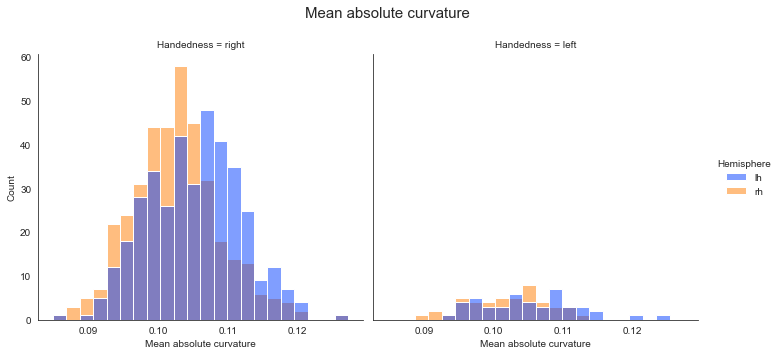

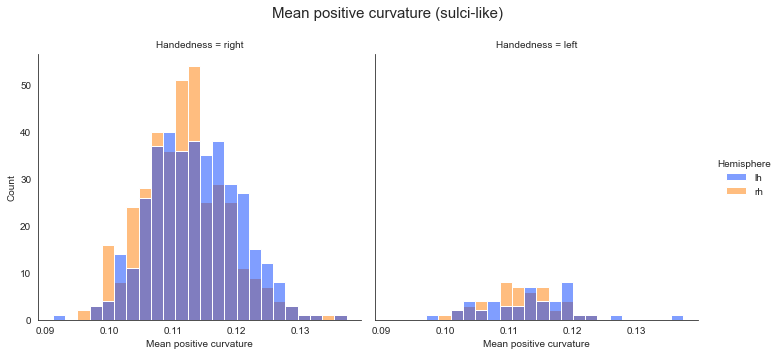

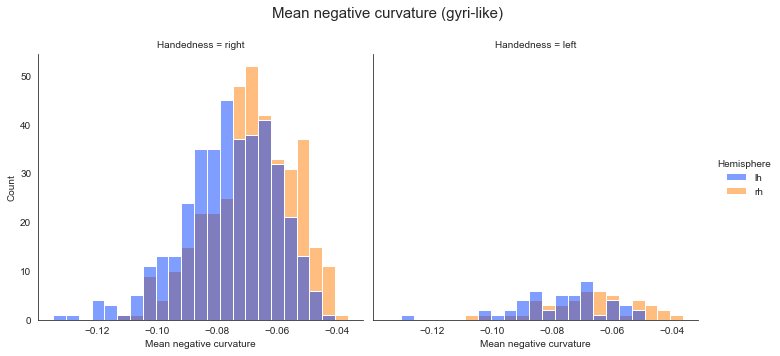

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

g = sns.displot(data=all_curv, x='Mean absolute curvature', hue='Hemisphere', col='Handedness', kind='hist', palette='bright')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Mean absolute curvature', fontsize=15)
plt.savefig('/Users/jwu/brainhack/bhPadova_2020/mean_abs_curv.png')
g = sns.displot(data=all_curv, x='Mean positive curvature', hue='Hemisphere', col='Handedness', kind='hist', palette='bright') # sulci
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Mean positive curvature (sulci-like)', fontsize=15)
plt.savefig('/Users/jwu/brainhack/bhPadova_2020/mean_pos_curv.png')
g = sns.displot(data=all_curv, x='Mean negative curvature', hue='Hemisphere', col='Handedness', kind='hist', palette='bright') # gyri
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Mean negative curvature (gyri-like)', fontsize=15)
plt.savefig('/Users/jwu/brainhack/bhPadova_2020/mean_neg_curv.png')

In [44]:
from scipy.stats import ttest_ind

t_abs, p_abs = ttest_ind(all_curv['Mean absolute curvature'].loc[all_curv['Hemisphere'] == 'lh'],
                     all_curv['Mean absolute curvature'].loc[all_curv['Hemisphere'] == 'rh'])
t_pos, p_pos = ttest_ind(all_curv['Mean positive curvature'].loc[all_curv['Hemisphere'] == 'lh'],
                     all_curv['Mean positive curvature'].loc[all_curv['Hemisphere'] == 'rh'])
t_neg, p_neg = ttest_ind(all_curv['Mean negative curvature'].loc[all_curv['Hemisphere'] == 'lh'],
                     all_curv['Mean negative curvature'].loc[all_curv['Hemisphere'] == 'rh'])
print("Comparing LH & RH: ")
print("Mean absolute curvature: p = %f, t = %f" % (p_abs, t_abs))
print("Mean positive curvature: p = %f, t = %f" % (p_pos, t_pos))
print("Mean negative curvature: p = %f, t = %f" % (p_neg, t_neg))
print("\t")

t_abs, p_abs = ttest_ind(all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'right'],
                         all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'left'])
t_pos, p_pos = ttest_ind(all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'right'],
                         all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'left'])
t_neg, p_neg = ttest_ind(all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'right'],
                         all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'left'])
print("Comparing right-handed & left-handed: ")
print("Mean absolute curvature: p = %f, t = %f" % (p_abs, t_abs))
print("Mean positive curvature: p = %f, t = %f" % (p_pos, t_pos))
print("Mean negative curvature: p = %f, t = %f" % (p_neg, t_neg))
print("\t")

t_abs, p_abs = ttest_ind(all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'lh'],
                         all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'lh'])
t_pos, p_pos = ttest_ind(all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'lh'],
                         all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'lh'])
t_neg, p_neg = ttest_ind(all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'lh'],
                         all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'lh'])
print("Comparing right-handed & left-handed in LH ONLY: ")
print("Mean absolute curvature: p = %f, t = %f" % (p_abs, t_abs))
print("Mean positive curvature: p = %f, t = %f" % (p_pos, t_pos))
print("Mean negative curvature: p = %f, t = %f" % (p_neg, t_neg))
print("\t")

t_abs, p_abs = ttest_ind(all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'rh'],
                         all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'rh'])
t_pos, p_pos = ttest_ind(all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'rh'],
                         all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'rh'])
t_neg, p_neg = ttest_ind(all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'rh'],
                         all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'rh'])
print("Comparing right-handed & left-handed in RH ONLY: ")
print("Mean absolute curvature: p = %f, t = %f" % (p_abs, t_abs))
print("Mean positive curvature: p = %f, t = %f" % (p_pos, t_pos))
print("Mean negative curvature: p = %f, t = %f" % (p_neg, t_neg))
print("\t")

Comparing LH & RH: 
Mean absolute curvature: p = 0.000000, t = 6.131258
Mean positive curvature: p = 0.000522, t = 3.482408
Mean negative curvature: p = 0.000000, t = -7.491414
	
Comparing right-handed & left-handed: 
Mean absolute curvature: p = 0.662083, t = 0.437192
Mean positive curvature: p = 0.721890, t = 0.356052
Mean negative curvature: p = 0.966847, t = -0.041575
	
Comparing right-handed & left-handed in LH ONLY: 
Mean absolute curvature: p = 0.945294, t = 0.068658
Mean positive curvature: p = 0.805206, t = 0.246770
Mean negative curvature: p = 0.814680, t = 0.234539
	
Comparing right-handed & left-handed in RH ONLY: 
Mean absolute curvature: p = 0.566724, t = 0.573333
Mean positive curvature: p = 0.796582, t = 0.257935
Mean negative curvature: p = 0.756867, t = -0.309798
	


In [45]:
from scipy.stats import levene

t_abs, p_abs = levene(all_curv['Mean absolute curvature'].loc[all_curv['Hemisphere'] == 'lh'],
                     all_curv['Mean absolute curvature'].loc[all_curv['Hemisphere'] == 'rh'])
t_pos, p_pos = levene(all_curv['Mean positive curvature'].loc[all_curv['Hemisphere'] == 'lh'],
                     all_curv['Mean positive curvature'].loc[all_curv['Hemisphere'] == 'rh'])
t_neg, p_neg = levene(all_curv['Mean negative curvature'].loc[all_curv['Hemisphere'] == 'lh'],
                     all_curv['Mean negative curvature'].loc[all_curv['Hemisphere'] == 'rh'])
print("Comparing LH & RH: ")
print("Mean absolute curvature: p = %f, t = %f" % (p_abs, t_abs))
print("Mean positive curvature: p = %f, t = %f" % (p_pos, t_pos))
print("Mean negative curvature: p = %f, t = %f" % (p_neg, t_neg))
print("\t")

t_abs, p_abs = levene(all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'right'],
                         all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'left'])
t_pos, p_pos = levene(all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'right'],
                         all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'left'])
t_neg, p_neg = levene(all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'right'],
                         all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'left'])
print("Comparing right-handed & left-handed: ")
print("Mean absolute curvature: p = %f, t = %f" % (p_abs, t_abs))
print("Mean positive curvature: p = %f, t = %f" % (p_pos, t_pos))
print("Mean negative curvature: p = %f, t = %f" % (p_neg, t_neg))
print("\t")

t_abs, p_abs = levene(all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'lh'],
                         all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'lh'])
t_pos, p_pos = levene(all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'lh'],
                         all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'lh'])
t_neg, p_neg = levene(all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'lh'],
                         all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'lh'])
print("Comparing right-handed & left-handed in LH ONLY: ")
print("Mean absolute curvature: p = %f, t = %f" % (p_abs, t_abs))
print("Mean positive curvature: p = %f, t = %f" % (p_pos, t_pos))
print("Mean negative curvature: p = %f, t = %f" % (p_neg, t_neg))
print("\t")

t_abs, p_abs = levene(all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'rh'],
                         all_curv['Mean absolute curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'rh'])
t_pos, p_pos = levene(all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'rh'],
                         all_curv['Mean positive curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'rh'])
t_neg, p_neg = levene(all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'right'].loc[all_curv['Hemisphere'] == 'rh'],
                         all_curv['Mean negative curvature'].loc[all_curv['Handedness'] == 'left'].loc[all_curv['Hemisphere'] == 'rh'])
print("Comparing right-handed & left-handed in RH ONLY: ")
print("Mean absolute curvature: p = %f, t = %f" % (p_abs, t_abs))
print("Mean positive curvature: p = %f, t = %f" % (p_pos, t_pos))
print("Mean negative curvature: p = %f, t = %f" % (p_neg, t_neg))
print("\t")

Comparing LH & RH: 
Mean absolute curvature: p = 0.019650, t = 5.463019
Mean positive curvature: p = 0.055057, t = 3.690303
Mean negative curvature: p = 0.179664, t = 1.803315
	
Comparing right-handed & left-handed: 
Mean absolute curvature: p = 0.886157, t = 0.020510
Mean positive curvature: p = 0.316721, t = 1.003622
Mean negative curvature: p = 0.698570, t = 0.150065
	
Comparing right-handed & left-handed in LH ONLY: 
Mean absolute curvature: p = 0.732392, t = 0.117081
Mean positive curvature: p = 0.927164, t = 0.008366
Mean negative curvature: p = 0.816076, t = 0.054168
	
Comparing right-handed & left-handed in RH ONLY: 
Mean absolute curvature: p = 0.787483, t = 0.072766
Mean positive curvature: p = 0.112814, t = 2.524831
Mean negative curvature: p = 0.506665, t = 0.441700
	
